# ML Pipeline Demonstration

This notebook demonstrates how to use the ML Pipeline for LGBM classification. It covers the basic functionality of each component and shows how they work together.

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the ML pipeline
from ml_pipeline import DataLoader, DataProcessor, ML_Pipeline

# Set up paths
TRAIN_CONFIG_PATH = "data_config_train.json"
TEST_CONFIG_PATH = "data_config_test.json"
MODEL_CONFIG_PATH = "model_config.json"

# Create output directory if it doesn't exist
os.makedirs("trained_model_outputs_path", exist_ok=True)

## 1. Data Loader Demonstration

First, let's demonstrate the DataLoader class which handles loading and validating the data.

In [6]:
metadata_df = pd.read_excel(metadata_path)
metadata_df

,Unnamed: 0,id_col,date_col,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,type,category,category,bool,float,float,float,float,float,float,float,float,float,float,category,category,bool,bool
1,use,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,imputation,unknown,unknown,unknown,mean,mean,mean,mean,mean,mean,mean,mean,mean,unknown,mode,unknown,0,unknown
3,category_transformation,None,None,NaN,Standardize,Standardize,Standardize,Standardize,Standardize,Standardize,Standardize,Standardize,Standardize,Standardize,one-hot,None,None,None
4,super_category,1_id,1_id,2_DEPENDENT,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features,3_features
5,variable_sign,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [8]:
metadata_path = "feature_metadata.xlsx"

metadata_df = pd.read_excel(metadata_path)


# Transform metadata_df to make it more usable
# First row contains column types
feature_types = metadata_df.iloc[0].to_dict()
# Second row contains usage flags
feature_use = metadata_df.iloc[1].to_dict()
# Third row contains imputation methods
feature_imputation = metadata_df.iloc[2].to_dict()
# Fourth row contains category transformations
feature_transformation = metadata_df.iloc[3].to_dict()
# Fifth row contains super categories
feature_super_category = metadata_df.iloc[4].to_dict()

# Create a clean DataFrame for easier access
feature_info = []
for col in metadata_df.columns:
    if col != "Unnamed: 0":
        feature_info.append({
            "feature_name": col,
            "type": feature_types.get(col, ""),
            "use": feature_use.get(col, 0),
            "imputation": feature_imputation.get(col, ""),
            "transformation": feature_transformation.get(col, ""),
            "super_category": feature_super_category.get(col, "")
        })

pd.DataFrame(feature_info)

,feature_name,type,use,imputation,transformation,super_category
0,id_col,category,0,unknown,None,1_id
1,date_col,category,0,unknown,None,1_id
2,target,bool,1,unknown,NaN,2_DEPENDENT
3,feature_0,float,1,mean,Standardize,3_features
4,feature_1,float,1,mean,Standardize,3_features
5,feature_2,float,1,mean,Standardize,3_features
6,feature_3,float,1,mean,Standardize,3_features
7,feature_4,float,1,mean,Standardize,3_features
8,feature_5,float,1,mean,Standardize,3_features
9,feature_6,float,1,mean,Standardize,3_features


In [2]:
# Initialize the data loader with training configuration
data_loader = DataLoader(TRAIN_CONFIG_PATH, MODEL_CONFIG_PATH)

# Get configurations
data_config = data_loader.get_data_config()
model_config = data_loader.get_model_config()

print("Data config:")
for key, value in data_config.items():
    print(f"  {key}: {value}")

print("\nModel config:")
for key, value in model_config.items():
    if key != "hyperparameter_space":  # Skip printing hyperparameter space for brevity
        print(f"  {key}: {value}")

Data config:
  training: True
  metadata_file_path: feature_metadata.xlsx
  input_data_source: CSV
  file_path: example_inputs_v1.csv

Model config:
  target_variable: target
  id_variables: ['id_col', 'date_col']
  problem_type: classification
  evaluation_metric: rocauc
  better_performance: gt
  models: ['lgbm']
  k_folds: 5
  retrain_with_whole_dataset: True
  sample_for_contribution: 1.0
  importance_extraction_method: treeinterpreter
  num_hp_searches: 5


In [3]:
# Get feature metadata
feature_metadata = data_loader.get_feature_metadata()
print("Feature metadata summary:")
print(f"  Total features: {len(feature_metadata)}")
print("\nFeature metadata preview:")
display(feature_metadata.head())

Feature metadata summary:
  Total features: 17

Feature metadata preview:


,feature_name,type,use,imputation,transformation,super_category
0,id_col,category,0,unknown,None,1_id
1,date_col,category,0,unknown,None,1_id
2,target,bool,1,unknown,NaN,2_DEPENDENT
3,feature_0,float,1,mean,Standardize,3_features
4,feature_1,float,1,mean,Standardize,3_features


In [4]:
# Get the data with correct data types
data = data_loader.get_data()
print("Data summary:")
print(f"  Shape: {data.shape}")
print(f"  Columns: {list(data.columns)}")
print("\nData preview:")
display(data.head())

print("\nData types:")
display(data.dtypes)

Data summary:
  Shape: (1000, 17)
  Columns: ['id_col', 'date_col', 'target', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13']

Data preview:


,id_col,date_col,target,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13
0,tMDgt,1/1/2025,True,0.049852,-0.089866,-1.737027,-0.563298,1.438655,0.423646,-0.571617,2.344470,0.329684,-1.687705,c,NaN,True,True
1,RgeWT,1/1/2025,True,0.600273,1.293923,-0.768878,-1.674227,0.656431,-0.030041,1.393623,-1.575807,1.485816,0.163634,b,NaN,True,False
2,BXjMC,1/1/2025,False,-2.998233,0.631200,1.180551,0.640171,-1.244864,-0.020427,0.127345,1.303097,-1.408630,-1.171414,b,e,False,False
3,hwtkX,1/1/2025,True,2.641943,0.117200,-1.211940,-0.171758,0.657611,-1.026694,0.446694,-1.116131,3.546071,0.043762,b,d,True,True
4,nJfRw,1/1/2025,False,-3.386397,1.547925,0.356687,0.930875,-0.673196,0.976374,0.154054,1.594067,-1.075212,-0.985810,c,e,False,True



Data types:


id_col        category
date_col      category
target            bool
feature_0      float64
feature_1      float64
feature_2      float64
feature_3      float64
feature_4      float64
feature_5      float64
feature_6      float64
feature_7      float64
feature_8      float64
feature_9      float64
feature_10    category
feature_11    category
feature_12        bool
feature_13        bool
dtype: object

## 2. Data Processor Demonstration

Next, let's demonstrate the DataProcessor class which handles preprocessing the data.

In [5]:
# Initialize the data processor
data_processor = DataProcessor(
    feature_metadata=feature_metadata,
    model_config=model_config,
    output_dir="trained_model_outputs_path"
)

# Print feature categorization
print("Feature categorization:")
print(f"  Numerical features: {data_processor.numerical_features}")
print(f"  Categorical features: {data_processor.categorical_features}")
print(f"  Binary features: {data_processor.binary_features}")
print(f"  One-hot features: {data_processor.one_hot_features}")
print(f"  Leave as NA features: {data_processor.leave_as_na_features}")

Feature categorization:
  Numerical features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
  Categorical features: ['feature_11']
  Binary features: ['feature_12', 'feature_13']
  One-hot features: ['feature_10']
  Leave as NA features: ['feature_9', 'feature_11', 'feature_13']


Created 5 folds for cross-validation


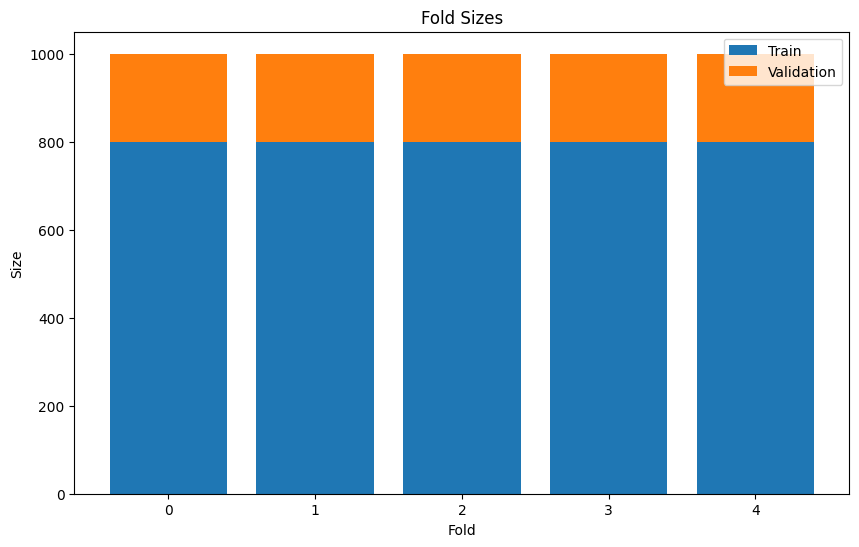

In [6]:
# Create folds for cross-validation
fold_indices = data_processor.create_folds(data)
print(f"Created {len(fold_indices)} folds for cross-validation")

# Visualize the fold sizes
fold_sizes = [(fold[0].shape[0], fold[1].shape[0]) for fold in fold_indices]
df_fold_sizes = pd.DataFrame(fold_sizes, columns=['train_size', 'val_size'])
df_fold_sizes['fold'] = range(len(fold_indices))

plt.figure(figsize=(10, 6))
plt.bar(df_fold_sizes['fold'], df_fold_sizes['train_size'], label='Train')
plt.bar(df_fold_sizes['fold'], df_fold_sizes['val_size'], bottom=df_fold_sizes['train_size'], label='Validation')
plt.xlabel('Fold')
plt.ylabel('Size')
plt.title('Fold Sizes')
plt.legend()
plt.show()

In [7]:
import sklearn
print(sklearn.__version__)

1.1.1


In [8]:
# Preprocess the training data
preprocessed_data = data_processor.preprocess_training_data(data, fold_indices)
print("Preprocessed data:")
print(f"  Original data shape: {preprocessed_data['original_data'].shape}")
print(f"  Features shape: {preprocessed_data['X'].shape}")
print(f"  Target shape: {preprocessed_data['y'].shape}")
print(f"  Number of folds: {len(preprocessed_data['folds'])}")

# Print info for the first fold
first_fold = preprocessed_data['folds'][0]
print("\nFirst fold:")
print(f"  Fold index: {first_fold['fold_idx']}")
print(f"  Training indices shape: {first_fold['train_idx'].shape}")
print(f"  Validation indices shape: {first_fold['val_idx'].shape}")
print(f"  X_train shape: {first_fold['X_train'].shape}")
print(f"  X_train_transformed shape: {first_fold['X_train_transformed'].shape}")
print(f"  X_val shape: {first_fold['X_val'].shape}")
print(f"  X_val_transformed shape: {first_fold['X_val_transformed'].shape}")

Preprocessed data:
  Original data shape: (1000, 17)
  Features shape: (1000, 14)
  Target shape: (1000,)
  Number of folds: 5

First fold:
  Fold index: 0
  Training indices shape: (800,)
  Validation indices shape: (200,)
  X_train shape: (800, 14)
  X_train_transformed shape: (800, 16)
  X_val shape: (200, 14)
  X_val_transformed shape: (200, 16)


In [12]:
first_fold['X_train_transformed']

array([[0.017815511098718952, -0.33588925767101896, -0.6211288918103318,
        ..., -1.6877048624258153, nan, 1.0],
       [-1.186430902470498, 0.13021433593035286, 1.2610221490320725, ...,
        -1.171414392093989, 'e', 0.0],
       [-1.3397876857851736, 0.7227928662180212, 0.7295414330866633, ...,
        -0.9858104964754728, 'e', 1.0],
       ...,
       [-0.3521519155857209, -0.6642829081596586, 2.293969803837601, ...,
        -0.387151055849824, 'd', 1.0],
       [-1.9090710446618038, 1.0778774785178176, 0.7946988087994016, ...,
        1.093313378668319, 'd', 1.0],
       [-0.2867320621077717, -0.08137767119522747, 0.8076263312630432,
        ..., -0.2002333353900266, 'd', 0.0]], dtype=object)

In [9]:
# Fit and transform the full dataset
X_transformed, y = data_processor.fit_transform_full_dataset(data)
print("Full dataset transformation:")
print(f"  X_transformed shape: {X_transformed.shape}")
print(f"  y shape: {y.shape}")

# Save the preprocessor
preprocessor_path = data_processor.save_preprocessor()
print(f"Preprocessor saved to: {preprocessor_path}")

Full dataset transformation:
  X_transformed shape: (1000, 16)
  y shape: (1000,)
Preprocessor saved to: trained_model_outputs_path/target_classification_lgbm_data_processor.pkl


## 3. ML Pipeline Demonstration

Finally, let's demonstrate the full ML_Pipeline class which integrates data loading, preprocessing, and model training.

In [13]:
# Initialize the ML pipeline for training
pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TRAIN_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if pipeline.is_training else 'testing'}")

# Run the pipeline for training
pipeline.run()

ML Pipeline initialized for training
Starting training pipeline...
Training lgbm models for classification problem...
Training fold 1/5...


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
# Check the model performances
performances = pipeline.get_model_performances()
print("Model performances:")
for perf in performances:
    print(f"  Fold {perf['fold_idx']}: {perf['performance']}")

# Visualize the performances
plt.figure(figsize=(10, 6))
plt.bar(range(len(performances)), [p['performance'] for p in performances])
plt.axhline(y=np.mean([p['performance'] for p in performances]), color='r', linestyle='-', label='Mean')
plt.xlabel('Fold')
plt.ylabel('Performance')
plt.title('Model Performances Across Folds')
plt.xticks(range(len(performances)), [f"Fold {p['fold_idx']}" for p in performances])
plt.legend()
plt.show()

In [ ]:
# Now initialize the ML pipeline for testing
test_pipeline = ML_Pipeline(MODEL_CONFIG_PATH, TEST_CONFIG_PATH)
print(f"ML Pipeline initialized for {'training' if test_pipeline.is_training else 'testing'}")

# Run the pipeline for testing
test_pipeline.run()

In [ ]:
# Load and display the predictions
predictions_path = test_pipeline.data_config.get("predictions_output_path", "")
if os.path.exists(predictions_path):
    predictions_df = pd.read_csv(predictions_path)
    print("Predictions:")
    print(f"  Shape: {predictions_df.shape}")
    print(f"  Columns: {list(predictions_df.columns)}")
    display(predictions_df.head())
    
    # Visualize the predictions distribution
    plt.figure(figsize=(10, 6))
    plt.hist(predictions_df['prediction'], bins=20)
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.title('Predictions Distribution')
    plt.show()
else:
    print(f"Predictions file not found at: {predictions_path}")

## 4. Optional: Feature Importance Analysis

If desired, we can analyze the feature importances from the trained LGBM model.

In [ ]:
# Load the trained model
import pickle

model_path = os.path.join("trained_model_outputs_path", "target_classification_lgbm.pkl")
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    
    # Get feature importances
    feature_importance = model.feature_importance()
    
    # Map feature indices to feature names
    feature_indices = list(range(len(feature_importance)))
    
    # Create a dataframe of feature importances
    importance_df = pd.DataFrame({
        'feature_idx': feature_indices,
        'importance': feature_importance
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    # Display feature importances
    print("Feature importances:")
    display(importance_df.head(10))
    
    # Visualize feature importances
    plt.figure(figsize=(12, 8))
    plt.bar(importance_df['feature_idx'].head(20), importance_df['importance'].head(20))
    plt.xlabel('Feature Index')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.xticks(importance_df['feature_idx'].head(20))
    plt.show()
else:
    print(f"Model file not found at: {model_path}")